# Image Deblurring - June Exam
## Guido Laudenzi - 0001033343

### Dataset creation - DO NOT MODIFY

In [ ]:
import tensorflow as tf 
import random
from cv2 import GaussianBlur
import numpy as np

def getDataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  normalize = lambda x: x/x.max()
  x_train = normalize(x_train)
  x_test = normalize(x_test)
  createBlurred = lambda arr: np.array([GaussianBlur(x, (5,5), ((random.random()*3)+1)) + (0.02*np.random.normal(0,1, (32, 32, 3))) for x in arr])
  return (createBlurred(x_train), x_train), (createBlurred(x_test), x_test)

#Dataset split and visualization

Importing libraries useful for the project.

In [ ]:
import gc
import pandas as pd
import matplotlib.pyplot as plt
from keras.layers import Input
from keras.layers import Conv2D, Conv2DTranspose
from keras.layers import LeakyReLU, BatchNormalization
from keras.models import Model
from keras.losses import mean_squared_error
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from sklearn.model_selection import KFold

Dividing the dataset in X and y, both for train and test. Validation set will be selected according to the K-Fold Cross Validation technique.

In [ ]:
(x, y), (x_test, y_test) = getDataset()

170508288/170498071 [==============================] - 2s 0us/step


Checking the shape of X in order to select the splitting size of X in train and validation.

In [ ]:
print("Train dataset shape: ", x.shape)
print("Test dataset shape: ", x_test.shape)

Train dataset shape:  (50000, 32, 32, 3)
Test dataset shape:  (10000, 32, 32, 3)


Plotting a clean and noisy random image.

Figure number: 44830


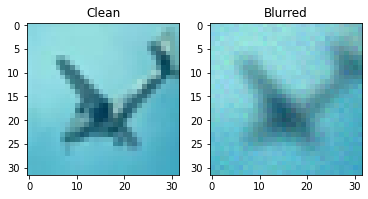

In [ ]:
# Random number
r = random.randint(0, len(y)-1)
print('Figure number:',r)

#Plot figures
fig = plt.figure()
fig.subplots_adjust(hspace=0.1, wspace=0.2)
ax = fig.add_subplot(1, 2, 1)
ax.set_title('Clean')
ax.imshow(y[r])
ax = fig.add_subplot(1, 2, 2)
ax.set_title('Blurred')
ax.imshow(x[r])

#Model creation

As model, I will be using a DCAE: a Denoising Convolutional AutoEncoder. In case of image data, the autoencoder will first encode the image into a lower-dimensional representation, then decodes that representation back to the image.

The Encoder-Decoder model consists of the following two structures:

*   **The encoder**: this network downsamples the data into lower dimensions.
*   **The decoder**: this network reconstructs the original data from the lower dimension representation.

The lower dimension (the output of encoder) representation is usually known as latent space representation.

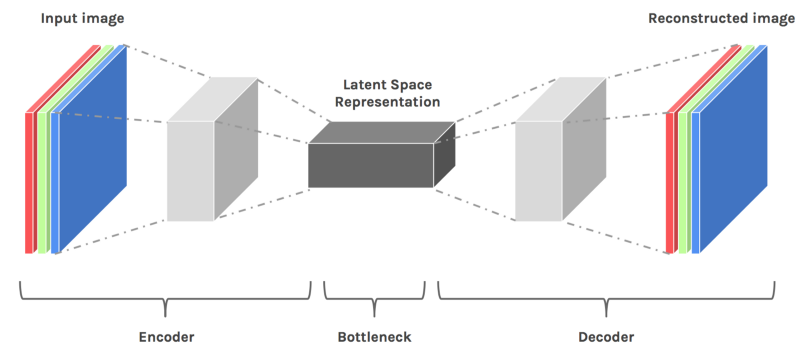

Autoencoders are only able to compress the data that is similar to what they have been trained on. They are also lossy in nature which means that the output will be degraded with respect to the original input.

Some useful parameters of the model:


*   *Input_shape*: the shape of the RGB images (32x32x3).
*   *Kernel_size*: the size of the Convolutional operation. A kernel 7x7 as first layer could be useful to obtain more information than a default 3x3.
*   *Num_strides*: the number of pixels shifts over the input matrix. Useful to reduce/augment the dimension of the image.
*   *Dilation_rates*: defines a spacing between the values in a kernel. Useful to obtain information from pixel that are not necessary adjacent to the one in study.
*   *Latent_space*: the classical way would be providing to the decoder a latent vector (1D) generated by the encoder. In this case, given that the images are very small (32x32), each pixel carries a lot of information and an higher dimension can be helpful not to lose it while training.
*   *Layer_filters*: the dimension of the Convolutional layers. Usually, the scheme of the autoencoder is a set of convolutions and then its symmetric.

Some parameters for training are the batch size and the number of traning epochs for each of the K-fold split.

In [ ]:
# Network Parameters
input_shape = (32, 32, 3)
kernel_size = [7, 5, 3]
num_strides = [2, 1, 1]
dilation_rates = [1, 2, 1]
latent_space = (16, 16, 256)

# Training parameters
batch_size = 64
num_epochs = 20

# Encoder/Decoder number of CNN layers and filters per layer
layer_filters = [64, 128, 256]

Initializing the input for the model.

In [ ]:
inputs = Input(shape = input_shape)

We are going to use the Functional API to build our convolutional autoencoder. The encoder and the decoder network will be symmetric so to return the image with the same shape as the input.

Both encoder and decoder will be using Convolutional Neural Networks with the previously defined parameters and:


*   *Batch normalization*: applies a transformation that maintains the mean output close to 0 and the output standard deviation close to 1.
$$BatchNorm = \gamma* Norm(x) + bias$$
Using bias in convolution layer and then again in batch normalization will cancel out the bias in the process of mean subtraction. Thus, in the previous Convolutional layers bias was set to False.

*   *Leaky ReLU*: is a type of activation function that helps to prevent the function from becoming saturated at 0. It has the same form as the ReLU, but it will leak some positive values to 0 if they are close enough to zero. Used to avoid problems like exploding & vanishing gradient. In this case, it performs better than ReLU.



In [ ]:
# Encoder model
def encoder_model(input, layer, kernel, strides, dilation):
    x = input

    for i in range(len(kernel)):
        x = Conv2D(filters=layer[i], kernel_size=kernel[i], strides=strides[i], dilation_rate=dilation[i], padding='same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)
        
    return Model(input, x, name="encoder")

Here is the summary of the encoder model.

In [ ]:
encoder = encoder_model(inputs, layer_filters, kernel_size, num_strides, dilation_rates)
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 16, 16, 64)        9408      
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 64)       256       
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       204800    
                                                                 
 batch_normalization_1 (Batc  (None, 16, 16, 128)      512       
 hNormalization)                                           

The decoder model will be using the Conv2DTransponse layer instead of the combination of Conv2D + UpSampling2D: using the first one will also upsample its input but the key difference is that the model should learn what is the best upsampling for the current job.

In [ ]:
def decoder_model(layer, latent, kernel, strides, dilation):
    latent_inputs = Input(shape=latent)
    x = latent_inputs

    for i in range(len(kernel)-1,-1,-1):
        x = Conv2DTranspose(filters=layer[i], kernel_size = kernel[i], strides=strides[i], dilation_rate=dilation[i], padding='same', use_bias = False)(x)
        x = BatchNormalization()(x)
        x = LeakyReLU()(x)

    outputs = Conv2D(filters=3, kernel_size=3, activation='sigmoid', padding='same')(x)

    return Model(latent_inputs, outputs, name="decoder")

Here is the summary of the decoder model.

In [ ]:
decoder = decoder_model(layer_filters, latent_space, kernel_size, num_strides, dilation_rates)
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 16, 16, 256)]     0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 16, 16, 256)      589824    
 nspose)                                                         
                                                                 
 batch_normalization_3 (Batc  (None, 16, 16, 256)      1024      
 hNormalization)                                                 
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 16, 16, 256)       0         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 16, 16, 128)      819200    
 ranspose)                                                       
                                                           

Finally, the creation of the Autoencoder, composed by the encoder and decoder networks.

In [ ]:
autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 encoder (Functional)        (None, 16, 16, 256)       510912    
                                                                 
 decoder (Functional)        (None, 32, 32, 3)         1813955   
                                                                 
Total params: 2,324,867
Trainable params: 2,323,075
Non-trainable params: 1,792
_________________________________________________________________


Then, the model is compiled using the accuracy as metrics, the mean-squared error as loss and Adam as optimizer with higher learning rate than the default.

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate = 0.002)

autoencoder.compile(loss='mse', optimizer=adam, metrics=["acc"])

The callbacks used in training are:


*   *ReduceLROnPlateau*: reduces the learning rate when a metric has stopped improving. In this case, the metric is the loss and the factor is kept large (default factor is 0.2) so to give more time to the training at different learning rates.
*   *EarlyStopping*: stops early the training if a metric does not improve after the given epochs (*patience*).



In [ ]:
lr_reducer = ReduceLROnPlateau(factor=0.5,
                               cooldown=0,
                               patience=6,
                               verbose=1,
                               min_lr=0.5e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=8)

callbacks = [lr_reducer, early_stop]

#Training the model

Finally, the training is performed using K-Fold Cross Validation: given that the training set is a set of 50000 images, one possible split proportion is 4/5 for the training set and 1/5 for the validation set. Basically, each image will be used 4 times for training and 1 time for the validation.

The training is relatively fast, lasting almost ~30 minutes overall and ~30 seconds each epoch, while trying to learning approximatively ~2M parameters. Overall epochs would be 100 but early stopping could decrease them.

At each split, the weights of the training are saved and then reloaded at the next training split so to decrease the memory consumption.


In [ ]:
# Useful variables
splits = 5
overall_history = []

kfold = KFold(n_splits=splits, shuffle=True)

# Initialize splits and save initial weights
autoencoder.save_weights('weights.h5')
nfold = 1

for train, val in kfold.split(x, y):

    print("=========================================================")
    print("Training model with K-Fold Cross Validation number ", nfold,"/",splits)
    print("=========================================================")

    print("Images used in train and validation:", train,val)

    # Load weights and fit them
    autoencoder.load_weights('weights.h5')
    history = autoencoder.fit(x[train],
                              y[train],
                              validation_data=(x[val], y[val]),
                              epochs=num_epochs,
                              shuffle=True,
                              callbacks=callbacks,  
                              batch_size=batch_size)
    autoencoder.save_weights('weights.h5')

    # Append history for overall plot
    overall_history.append(history)
    nfold += 1

    # Cleaning session and garbage collector so to avoid RAM out of memory
    K.clear_session()
    gc.collect()

Training model with K-Fold Cross Validation number  1 / 5
Images used in train and validation: [    0     1     2 ... 49995 49996 49997] [   13    16    21 ... 49993 49998 49999]
Epoch 1/20
625/625 [==============================] - 38s 47ms/step - loss: 0.0085 - acc: 0.7154 - val_loss: 0.0050 - val_acc: 0.7894 - lr: 0.0020
Epoch 2/20
625/625 [==============================] - 29s 47ms/step - loss: 0.0044 - acc: 0.7942 - val_loss: 0.0037 - val_acc: 0.7784 - lr: 0.0020
Epoch 3/20
625/625 [==============================] - 29s 47ms/step - loss: 0.0038 - acc: 0.8048 - val_loss: 0.0033 - val_acc: 0.8079 - lr: 0.0020
Epoch 4/20
625/625 [==============================] - 29s 47ms/step - loss: 0.0035 - acc: 0.8118 - val_loss: 0.0038 - val_acc: 0.8010 - lr: 0.0020
Epoch 5/20
625/625 [==============================] - 29s 47ms/step - loss: 0.0032 - acc: 0.8162 - val_loss: 0.0035 - val_acc: 0.7971 - lr: 0.0020
Epoch 6/20
625/625 [==============================] - 30s 48ms/step - loss: 0.0031 - a

#Results and evaluation metrics

When the training is finished, it is possible to evaluate the results. 

The most informative plot is the one of the MSE, because the accuracy only provides a representation in terms of pixels equality. The Mean Squared Error (MSE) is calculated taking the difference between the model's predictions and the ground truth, square it, and average it out across the whole dataset.

Vertical lines indicate different K-fold trainings.

It is worth to notice that it seems like this kind of task does not suffer of overfitting or underfitting, even using bigger models with more parameters. The autoencoder keeps learning smoothly until the end of each K-fold training.

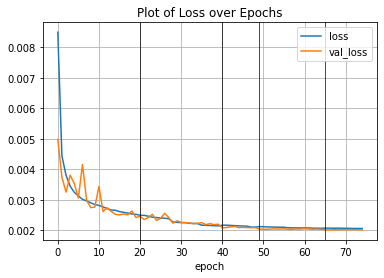

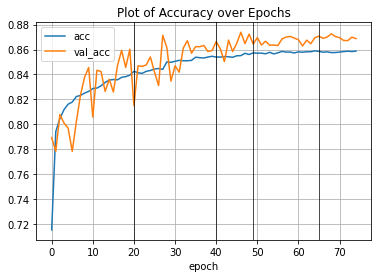

In [ ]:
# Vertical lines generator 
xcoords = [len(hist.history['loss']) for hist in overall_history[:-1]]
tmp=xcoords[0]
tmp1=0

for i in range(1,len(xcoords)):
  tmp1=xcoords[i]
  xcoords[i]+=tmp
  tmp+=tmp1

# Loss
plt.plot([hist.history['loss'][i] for hist in overall_history for i in range(len(hist.history['loss']))])
plt.plot([hist.history['val_loss'][i] for hist in overall_history for i in range(len(hist.history['val_loss']))])
plt.grid()
plt.xlabel('epoch')
for xc in xcoords:
    plt.axvline(x=xc, color="black", linewidth=0.7)
plt.legend(['loss', 'val_loss'])
plt.title('Plot of Loss over Epochs')
plt.show()

# Accuracy
plt.plot([hist.history['acc'][i] for hist in overall_history for i in range(len(hist.history['acc']))])
plt.plot([hist.history['val_acc'][i] for hist in overall_history for i in range(len(hist.history['val_acc']))])
plt.grid()
plt.xlabel('epoch')
for xc in xcoords:
    plt.axvline(x=xc, color="black", linewidth=0.7)
plt.legend(['acc', 'val_acc'])
plt.title('Plot of Accuracy over Epochs')
plt.show()

In order to obtain the **MSE** on the test set, and so to see the model performance denoising a set of new images, there are two possible ways. 


1.  Manually compute the mean-squared error using the *predict* function of tensorflow and then applying the mean to the whole set.
2.   Directly use the *evaluate* procedure on the test set. Computation is done in batches (default *batch_size* is 32).



In [ ]:
y_pred = autoencoder.predict(x_test)
loss = mean_squared_error(y_test, y_pred)
print("The MSE is:", np.mean(loss))

The MSE is: 0.0021733153


The MSE results are equal, but the second method can provide the accuracy.



In [ ]:
mse, acc = autoencoder.evaluate(x_test, y_test)
print("MSE on test set:", round(mse,7))
print("Accuracy on test set:", round(acc,7))

313/313 [==============================] - 3s 10ms/step - loss: 0.0022 - acc: 0.8690
MSE on test set: 0.0021733
Accuracy on test set: 0.8690285


More than the MSE, visualizing the predicted images can be more useful to understand the quality of the model.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


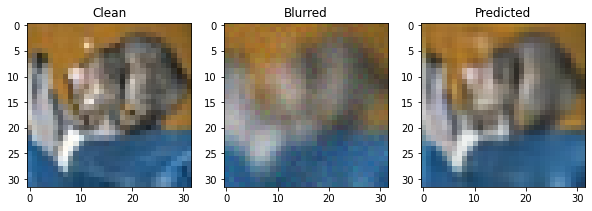

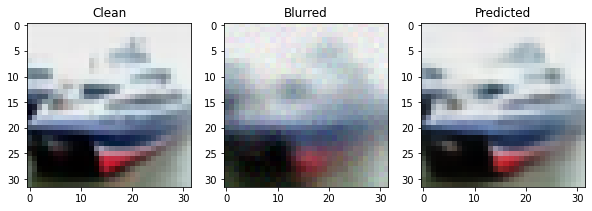

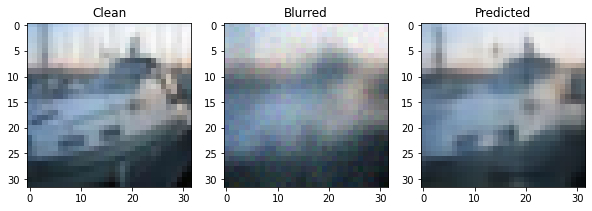

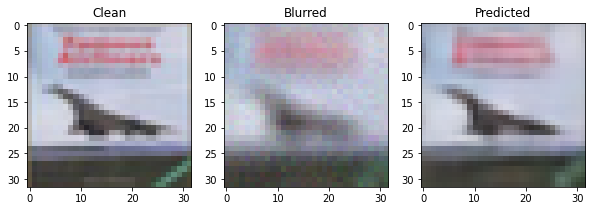

In [ ]:
for i in range(4):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 3, 1)
  ax.set_title('Clean')
  ax.imshow(y_test[i])
  ax = fig.add_subplot(1, 3, 2)
  ax.set_title('Blurred')
  ax.imshow(x_test[i])
  ax = fig.add_subplot(1, 3, 3)
  ax.set_title('Predicted')
  ax.imshow(y_pred[i])

##Other metrics

**MSE** is the most common estimator of image quality measurement metric. It is a full reference metric and the values closer to zero are the better.
Anyway, it is not the only metric to estimate the image quality. Others are the Peak Signal to Noise Ratio (PSNR) and the Structure Similarity Index Method (SSIM).

**PSNR** is used to calculate the ratio between the maximum possible signal power and the power of the distorting noise which affects the quality of its representation. This ratio between two images is computed in decibel form.
$$PSNR=10\log_{10}\frac{peak^2}{MSE}$$
Usually, the higher the better.

In [ ]:
print("PSNR score is:", np.mean(tf.image.psnr(y_test, y_pred, 1.0)))

PSNR score is: 27.148193


**SSIM** is a perception based model. In this method, image degradation is considered as the change of perception in structural information. It also collaborates some other important perception based fact such as luminance masking, contrast masking, etc. 
This metric is a more "subjective" metric than the others and better represent the visual quality of an image.

$$SSIM(x,y)=[l(x,y)]^\alpha \cdot [c(x,y)]^\beta \cdot [s(x,y)]^\gamma$$

Where *l* is the luminance (used to compare the brightness between two images), *c* is the contrast (used to differ the ranges between the brightest and darkest region of two images) and *s* is the structure (used to compare the local luminance pattern between two images to find the similarity and dissimilarity of the images) and *α*, *β* and *γ* are the positive constants.

SSIM value range is between 0 and 1 and usually, the higher the better.

In [ ]:
t = []

for i in range(len(y_test)):
  im1 = tf.expand_dims(y_test[i], axis=0)
  im2 = tf.expand_dims(y_pred[i], axis=0)
  im1 = tf.image.convert_image_dtype(im1, tf.float32)
  im2 = tf.image.convert_image_dtype(im2, tf.float32)

  t.append(np.mean(tf.image.ssim(im1, im2, 1.0)))

print("SSIM score is", np.mean(t))

SSIM score is 0.87672126


#Alternatives and improvements

If the need is having a faster model in terms of computation, the easiest way would be changing the kernel size of each Convolutional layer to 3x3. Doing so, the pixel predicted would depend less on more distant pixels, MSE, PSNR and SSIM would worsen (~0.00225 for MSE, still very low) and the overall quality image decrease (model struggles to find particular pixels, i.e. patterns with high constrast with adjacents). Anyway, the parameters needed to be trained would be approximately ~1M.

Otherwise, better looking images could be reached using Generative Adversarial Networks (GANs) but the metric would worsen because of the generative nature.

Autoencoders are the way to go with small images like the ones of this dataset.

#References

*   https://keras.io/api/
*   https://arxiv.org/pdf/2002.10444.pdf
*   https://www.tensorflow.org/tutorials
*   https://fleuret.org/dlc/materials/dlc-handout-7-2-autoencoders.pdf
*   https://www.scirp.org/journal/paperinformation.aspx?paperid=90911
*   https://www.analyticsvidhya.com/blog/2021/07/image-denoising-using-autoencoders-a-beginners-guide-to-deep-learning-project/